In [36]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes
from pycocotools.coco import COCO
from os.path import abspath, expanduser
from typing import Dict, List, Union
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [2]:
class Compose(object):
    def __init__(self, train=False):
        if train:
            self.transforms = [
                T.Resize(size=(400, 400)),
                T.ToTensor(),
                T.RandomHorizontalFlip(p=0.3),
                T.RandomVerticalFlip(p=0.3),
            ]
        else:
            self.transforms = [T.Resize(size=(400, 400)), T.ToTensor()]

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

In [67]:
class WIDERFace(Dataset):
    BASE_FOLDER = "widerface"

    def __init__(self, root, split="train", transform=None):
        # check arguments
        self.root = os.path.join(root, self.BASE_FOLDER)
        self.transform = transform
        self.split = split
        self.img_info: List[Dict[str, Union[str, Dict[str, torch.Tensor]]]] = []

        if self.split in ("train", "val"):
            self.parse_train_val_annotations_file()
        else:
            self.parse_test_annotations_file()

    def __getitem__(self, index: int):
        img = Image.open(self.img_info[index]["img_path"]).convert("RGB")
        img_shape = np.array(img)
        img_h = img_shape.shape[0]
        img_w = img_shape.shape[1]
        boxes = self.img_info[index]["annotations"]["bbox"]
        boxes[:, 0] /= img_w
        boxes[:, 1] /= img_h
        boxes[:, 2] /= img_w
        boxes[:, 3] /= img_h
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
            
        new_boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        if self.transform is not None:
            img, new_boxes = self.transform(img, new_boxes)
        
        label = {"boxes": new_boxes, "label": torch.tensor([0 for i in range(new_boxes.size(0))])}
        return img, label

    def __len__(self):
        return len(self.img_info)

    def extra_repr(self):
        lines = ["Split: {split}"]
        return "\n".join(lines).format(**self.__dict__)

    def parse_train_val_annotations_file(self):
        filename = "wider_face_train_bbx_gt.txt" if self.split == "train" else "wider_face_val_bbx_gt.txt"
        filepath = os.path.join(self.root, "wider_face_split", filename)

        with open(filepath) as f:
            lines = f.readlines()
            file_name_line, num_boxes_line, box_annotation_line = True, False, False
            num_boxes, box_counter = 0, 0
            labels = []
            for line in lines:
                line = line.rstrip()
                if file_name_line:
                    img_path = os.path.join(self.root, "WIDER_" + self.split,
                                            "images", line)
                    if not os.path.isfile(img_path):
                        continue
                    img_path = abspath(expanduser(img_path))
                    file_name_line = False
                    num_boxes_line = True
                elif num_boxes_line:
                    num_boxes = int(line)
                    num_boxes_line = False
                    box_annotation_line = True
                elif box_annotation_line:
                    box_counter += 1
                    line_split = line.split(" ")
                    line_values = [int(x) for x in line_split]
                    labels.append(line_values)
                    if box_counter >= num_boxes:
                        box_annotation_line = False
                        file_name_line = True
                        labels_tensor = torch.tensor(labels)[:, 0:4].float()
                        self.img_info.append(
                            {
                                "img_path": img_path,
                                "annotations": {
                                    "bbox": labels_tensor
                                    # x, y, width, height
                                },
                            }
                        )
                        box_counter = 0
                        labels.clear()
                else:
                    raise RuntimeError(
                        f"Error parsing annotation file {filepath}")

In [68]:
transform = Compose(train=True)
transform_test = Compose(train=False)
train_data = WIDERFace(root="data/", split="train", transform=transform)
test_data = WIDERFace(root="data/", split="val", transform=transform_test)

In [69]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [70]:
batch_size = 3
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle=True, collate_fn=collate_fn)

In [71]:
images, targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]

In [72]:
targets

[{'boxes': tensor([[0.6025, 0.1153, 0.8799, 0.3667]]), 'label': tensor([0])},
 {'boxes': tensor([[0.1348, 0.3206, 0.1504, 0.3646],
          [0.0088, 0.3206, 0.0293, 0.3646],
          [0.0225, 0.4129, 0.0449, 0.4671],
          [0.8359, 0.3294, 0.8545, 0.3734],
          [0.9268, 0.3045, 0.9424, 0.3514],
          [0.9697, 0.3089, 0.9893, 0.3485],
          [0.3779, 0.3016, 0.3848, 0.3499],
          [0.6230, 0.2694, 0.6338, 0.3250],
          [0.1475, 0.1772, 0.1543, 0.1918],
          [0.2021, 0.1757, 0.2090, 0.1918],
          [0.2568, 0.1772, 0.2627, 0.1918],
          [0.3125, 0.1772, 0.3193, 0.1918],
          [0.3662, 0.1772, 0.3730, 0.1918],
          [0.4209, 0.1772, 0.4268, 0.1903],
          [0.5654, 0.1742, 0.5713, 0.1889],
          [0.6201, 0.1772, 0.6270, 0.1903],
          [0.6758, 0.1742, 0.6816, 0.1889],
          [0.7314, 0.1757, 0.7373, 0.1903],
          [0.7871, 0.1742, 0.7949, 0.1874],
          [0.8438, 0.1728, 0.8496, 0.1859],
          [0.8193, 0.3177, 0.8242

In [91]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = FT.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

<ipython-input-92-e9fdfb0d467e>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_int = torch.tensor(img * 255, dtype=torch.uint8)


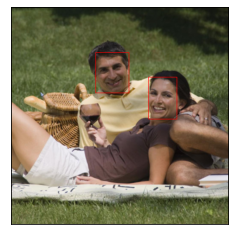

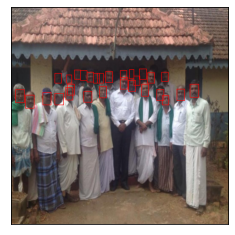

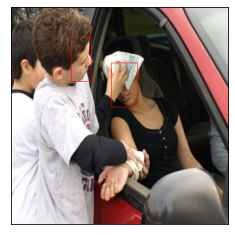

In [92]:
for (x,y) in test_loader:
    for i in range(len(images)):
        img = x[i]
        sample_y = y[i]["boxes"]
        sample_y *= 400
        img_int = torch.tensor(img * 255, dtype=torch.uint8)
        drawn_boxes = draw_bounding_boxes(img_int, sample_y, colors="red")
        show(drawn_boxes)
    break

In [76]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision
preds = [dict(boxes=torch.tensor([[258.0, 41.0, 606.0, 285.0],[2.2, 1.2, 2.2, 1.2]]),scores=torch.tensor([0.536, 0.6]),labels=torch.tensor([0, 0]),)]
target = [dict(boxes=torch.tensor([[214.0, 41.0, 562.0, 285.0], [2.3, 1.3, 2.3, 1.3]]),labels=torch.tensor([0, 0]),)]
metric = MeanAveragePrecision()
metric.update(preds, target)
maps = metric.compute()